In [1]:
import numpy as np
import scipy
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('C:\\Users\\zhouzhou\\Desktop\\code\\RF\\data2.csv',encoding='utf-8')

In [3]:
df.exist.nunique()

2

In [4]:
# Labelled as whether or not a debris flow has occurred, and labelled as 1 if it has occurred, and 0 otherwise.
df.exist.value_counts()

0    624
1    446
Name: exist, dtype: int64

In [5]:
y=df.exist
y.head()

0    0
1    1
2    0
3    1
4    0
Name: exist, dtype: int64

In [6]:
# x is the remaining data after deleting the label column
x=df.drop('exist', axis=1)

In [7]:
# Dividing the data in a 7:3 ratio for training and testing respectively
seed=5
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=seed)

In [8]:
# Train a random forest model using initial parameters and output the initial accuracy of the model
rfc = RandomForestClassifier()     
rfc = rfc.fit(xtrain,ytrain)       
result = rfc.score(xtest,ytest)   
result

0.7632398753894081

In [9]:
# AUC
roc_auc_score(ytest, rfc.predict_proba(xtest)[:,1]) 

0.8256206756206756

In [10]:
print ('feature important ：%s' % rfc.feature_importances_)

feature important ：[0.04151414 0.12831994 0.16108441 0.05906918 0.06652566 0.05061659
 0.05105783 0.         0.04446956 0.03874184 0.08367926 0.
 0.         0.04979085 0.10510053 0.04167948 0.03734577 0.04100497]


Feature ranking:
 1) Average slope                  0.161084
 2) Relative elevation difference  0.128320
 3) Average rainfall during the rainy season 0.105101
 4) Density of urban quaternary roads 0.083679
 5) Clay content                   0.066526
 6) NDVI                           0.059069
 7) Silt content                   0.051058
 8) Sand content                   0.050617
 9) Fracture zone density          0.049791
10) Density of urban secondary roads 0.044470
11) Number of rainstorms           0.041679
12) Watershed area                 0.041514
13) Number of heavy rains          0.041005
14) Density of urban tertiary roads 0.038742
15) Number of heavy rainstorms     0.037346
16) Density of urban primary roads 0.000000
17) Highway density                0.000000
18) Railway density                0.000000


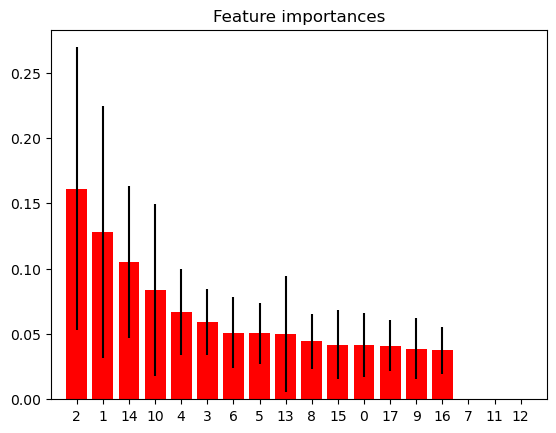

In [11]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]# Print the feature ranking
print("Feature ranking:")
for f in range(min(20,xtrain.shape[1])):    
    print("%2d) %-*s %f" % (f + 1, 30, xtrain.columns[indices[f]], importances[indices[f]]))# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(xtrain.shape[1]), importances[indices],  color="r", yerr=std[indices], align="center")
plt.xticks(range(xtrain.shape[1]), indices)
plt.xlim([-1, xtrain.shape[1]])
plt.show()

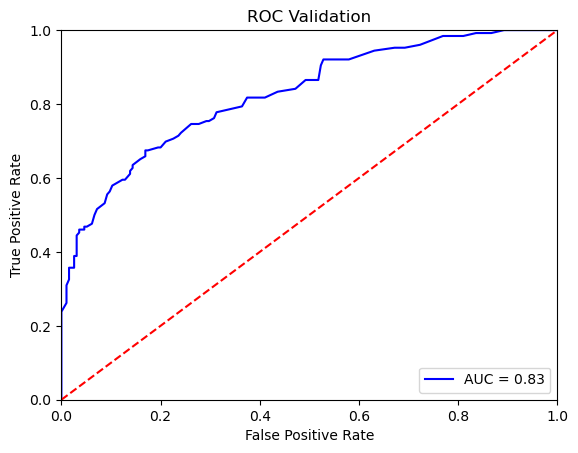

In [12]:
predictions_validation = rfc.predict_proba(xtest)[:,1]
fpr, tpr, _ = roc_curve(ytest, predictions_validation)
roc_auc = auc(fpr, tpr)
plt.title('ROC Validation')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [13]:
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
scores = cross_val_score(clf, xtrain, ytrain)
print(scores.mean())                             

clf2 = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
scores = cross_val_score(clf2, xtrain, ytrain)
print(scores.mean())                             

0.7075973154362416
0.7770917225950783


In [14]:
rfc.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier()>

In [18]:
#25-500 for parameter(n_estimators) tuning in steps of 25
param_test1 = {'n_estimators': range(25,500,25)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100, 
                                                           min_samples_leaf=20,
                                                           max_depth=8, random_state=10), 
                        param_grid = param_test1, 
                        scoring='roc_auc', 
                        cv=5)
gsearch1.fit(xtrain, ytrain)
print(gsearch1.best_params_, gsearch1.best_score_)
# # Print the best hyperparameter and the ROC value at the time the value was taken

{'n_estimators': 75} 0.822484610123119


In [25]:
param_test2 = {'min_samples_split':range(60, 200, 20), 'min_samples_leaf':range(10, 110, 10)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=75,
                                                           max_depth=8, random_state=10), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        cv=5)
gsearch2.fit(xtrain,ytrain)
print(gsearch2.best_params_, gsearch2.best_score_)

{'min_samples_leaf': 10, 'min_samples_split': 60} 0.8305813953488371


In [19]:
param_test3 = {'max_depth':range(3, 30, 1)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=75,
                                                           min_samples_split=60, 
                                                           min_samples_leaf=10,
                                                           random_state=10), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        cv=5)
gsearch3.fit(xtrain,ytrain)
print(gsearch3.best_params_, gsearch3.best_score_)

{'max_depth': 8} 0.8305813953488371


In [20]:
roc_auc_score(ytest, gsearch3.best_estimator_.predict_proba(xtest)[:,1])

0.7873422873422874

In [28]:
gsearch3.best_estimator_

RandomForestClassifier(max_depth=11, min_samples_leaf=10, min_samples_split=60,
                       n_estimators=75, random_state=10)

In [26]:
param_test4 = {'criterion':['gini', 'entropy'], 'class_weight':[None, 'balanced']}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=75,
                                                           max_depth=8, 
                                                           min_samples_split=60, 
                                                           min_samples_leaf=10,
                                                           random_state=10), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        cv=5)
gsearch4.fit(xtrain,ytrain)
print(gsearch4.best_params_, gsearch4.best_score_)

{'class_weight': 'balanced', 'criterion': 'entropy'} 0.8342600034199726


In [27]:
roc_auc_score(ytest, gsearch4.best_estimator_.predict_proba(xtest)[:,1])

0.7926332926332926

In [28]:
gsearch4.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, min_samples_leaf=10, min_samples_split=60,
                       n_estimators=75, random_state=10)

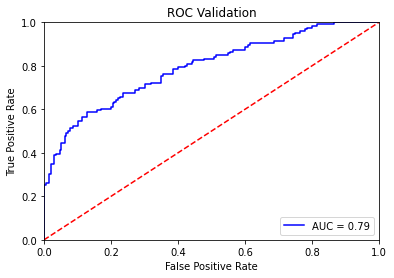

In [29]:
predictions_validation = gsearch4.predict_proba(xtest)[:,1]
fpr, tpr, _ = roc_curve(ytest, predictions_validation)
roc_auc = auc(fpr, tpr)
plt.title('ROC Validation')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()